ResNeXt_mpa(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_si

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


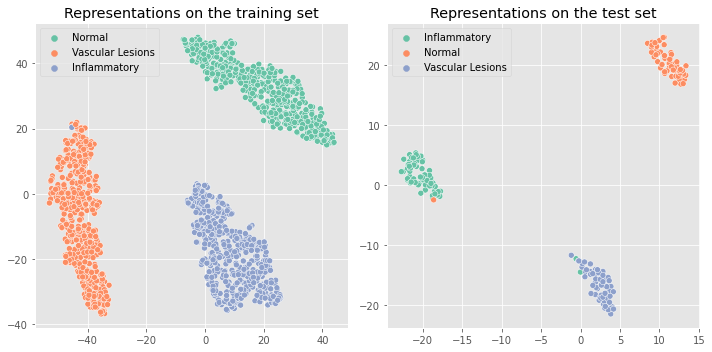

In [10]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import argparse
import os
import logging
import numpy as np
import torch.optim as optim
import random
from torch.utils.data import random_split,Dataset,DataLoader
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import f1_score
from resnext50 import ResNeXt50_32x4d
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import SNRDistance
torch.set_printoptions(sci_mode=False)
from sklearn.manifold import TSNE
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# get all args for the learning process

torch.set_printoptions(sci_mode=False) # close sci_model like 0.001 instead of 1e-3

torch.autograd.set_detect_anomaly(True)
# get all args for the learning process
def get_args():
    parser = argparse.ArgumentParser(description="Args for CADCAP")
    parser.add_argument("--dataset",
                        type=str,
                        default="CADCAP",
                        help="DATASETNAME'")
    parser.add_argument("--datadir",
                        type=str,
                        default="../data/MICCAI_wcetraining811",
                        help="Dir of your dataset, like '/data/DATASETNAME'")
    parser.add_argument("--num_workers",
                        type=int,
                        default=12,
                        help="Number of workers for loading the data")
    parser.add_argument("--model",
                        type=str,
                        default="ResNext50_32x4d",
                        help="Model name, default=ResNeXt50_32x4d")
    parser.add_argument("--num_classes",
                        type=int,
                        default=3,
                        help="Number of classes, default: 3")
    parser.add_argument("--batch_size",
                        type=int,
                        default=64,
                        help="Batch size, default=64")
    parser.add_argument("--seed",
                        type=int,
                        default=42,
                        help="Random seed, default=42")
    parser.add_argument("--epochs",
                        type=int,
                        default=30,
                        help="Max training epochs, default=50")
    parser.add_argument("--optimizer",
                        type=str,
                        default="SGD",
                        help="optimizer, default=SGD")
    parser.add_argument("--lr",
                        type=float,
                        default=0.01,
                        help="learning rate (default: 0.01)")
    parser.add_argument("--weight_decay",
                        type=float,
                        default=0.0000,
                        help="weight-decay (default: 0.0000)")
    parser.add_argument("--gpu",
                        type=str,
                        default="0",
                        help="input visible devices for training (default: cuda:0)")
    args = parser.parse_args(args=[])
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    return args


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def load_data(_args):
    dataset_dir = _args.datadir
    train_dir = os.path.join(dataset_dir, 'train')
    valid_dir = os.path.join(dataset_dir, 'valid')
    test_dir = os.path.join(dataset_dir, 'test')

    image_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.3663, 0.2485, 0.1391),
                                 std =(0.2628, 0.1856, 0.1255))
        ]),
        'valid': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.3663, 0.2485, 0.1391),
                                 std =(0.2628, 0.1856, 0.1255))
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.3663, 0.2485, 0.1391),
                                 std =(0.2628, 0.1856, 0.1255))
        ])
    }
    
    
    
    # dataset = datasets.ImageFolder(root=dataset_dir)
    # train_size = int(split_ratio[0] * len(dataset))
    # valid_size = int(split_ratio[1] * len(dataset))
    # test_size = len(dataset) - train_size - valid_size
    # raw_train_dataset, raw_valid_dataset, raw_test_dataset = random_split(dataset, [train_size, valid_size, test_size])
    
    
    train_dataset=datasets.ImageFolder(train_dir,image_transforms['train'])
    valid_dataset=datasets.ImageFolder(valid_dir,image_transforms['valid'])
    test_dataset=datasets.ImageFolder(test_dir,image_transforms['test'])
    
    
    train_loader = DataLoader(train_dataset, batch_size=_args.batch_size, num_workers=_args.num_workers, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=_args.batch_size, num_workers=_args.num_workers, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=_args.batch_size, num_workers=_args.num_workers, shuffle=False)

    train_data_size = len(train_dataset)
    valid_data_size = len(valid_dataset)
    test_data_size = len(test_dataset)
    
    # class_weight = get_weight(train_dataset, _args)
    
    return train_loader, valid_loader, test_loader, train_data_size, valid_data_size, test_data_size







def evaluate(_test_loader,_model,_args):
    test_start = time.time()
    test_loss = 0.0
    test_acc = 0.0
    _model.eval()
    embs = []
    labs = []
    for i, (inputs, targets) in enumerate(tqdm(_test_loader)):
        inputs = inputs.to(f"cuda:{_args.gpu}")
        targets = targets.to(f"cuda:{_args.gpu}")
        outputs,embeddings = _model(inputs)
        embs.append(embeddings.data.cpu())
        labs.append(targets.data.cpu())
    embs = torch.cat(embs, dim=0)
    labs = torch.cat(labs, dim=0)

    print(sorted(sklearn.neighbors.VALID_METRICS['brute']))
    tsne = TSNE(n_components=2, learning_rate=200,n_jobs=-1)
    tsne.fit_transform(embs)
    # 可视化训练集和测试集的嵌入
    plt.figure(figsize=(10, 5))

    # 训练集可视化
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=train_embeddings_tsne[:, 0], y=train_embeddings_tsne[:, 1], hue=train_labels, palette='Set1')
    plt.title('Train Set t-SNE Visualization')

    # 测试集可视化
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=test_embeddings_tsne[:, 0], y=test_embeddings_tsne[:, 1], hue=test_labels, palette='Set1')
    plt.title('Test Set t-SNE Visualization')

    plt.tight_layout()
    plt.show()
    outs_2d = np.array(tsne.embedding_)
    # css4 = list(mcolors.CSS4_COLORS.keys())
    # color_ind = [2,7,9,10,11,13,14,16,17,19,20,21,25,28,30,31,32,37,38,40,47,51]
    # css4 = [css4[v] for v in color_ind]
    for lbi in range(10):
        temp = outs_2d[labs==lbi]
        plt.plot(temp[:,0],temp[:,1],'.')
    plt.title('Feature embedding with triplet loss by t-SNE visualization')
    plt.savefig(f"./figures/{_args.dataset}_{len(_test_loader)}samples.png",dpi=600)
        
def get_embeddings(loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for j,(images, targets) in enumerate(tqdm(loader)):
            images = images.to("cuda:0")
            outputs, _,embeddings_batch = model(images)
            embeddings.append(embeddings_batch.cpu())
            labels.append(targets.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels


def main():
    #-------Load hyperparameters-------#
    args = get_args()
    setup_seed(seed=args.seed)

    
    #-------Load data-------#
    global train_data_size, valid_data_size, test_data_size
    train_loader, valid_loader, test_loader, train_data_size, valid_data_size, test_data_size = load_data(args)
    #-------Create model-------#
    model_file="./model/tSNE_BaselineTripletDCLPAE_datasetCADCAP3classes811_testacc0.9836_f1score0.9837_mpaTriplet_modelResNext50_32x4d_bs64_seed42_epochs30_optimSGD_lr0.01_wd0.0.pt"
    global model
    model = torch.load(model_file)
    
    #--------Use cuda------#
    model.to("cuda:{}".format(args.gpu))
    
    train_embeddings, train_labels = get_embeddings(train_loader)
    test_embeddings, test_labels = get_embeddings(test_loader)
    #-------Training-------#
    # evaluate(test_loader, model,args)
    tsne = TSNE(n_components=2)
    train_embeddings_tsne = tsne.fit_transform(train_embeddings)
    test_embeddings_tsne = tsne.fit_transform(test_embeddings)
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    label_list = ["Inflammatory", "Normal", "Vascular Lesions"]
    train_labels = [label_list[index] for index in train_labels]
    test_labels = [label_list[index] for index in test_labels]
    sns.scatterplot(x=train_embeddings_tsne[:, 0], y=train_embeddings_tsne[:, 1], hue=train_labels, palette='Set2')
    plt.title('Representations on the training set')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=test_embeddings_tsne[:, 0], y=test_embeddings_tsne[:, 1], hue=test_labels, palette='Set2')
    plt.title('Representations on the test set')
    plt.tight_layout()
    plt.savefig(f"./figures/{args.dataset}tripletDCLPAE_train_test_tSNE.png",dpi=600)
    plt.show()
if __name__ == "__main__":
    main()


    